In [19]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the metadata
metadata = pd.read_csv('ISIC_2020_Training_GroundTruth (1).csv')

# Add a column for the full path to each image
metadata['image_path'] = metadata['image_name'].apply(lambda x: os.path.join('images/train', f'{x}.jpg'))

# Verify if the paths are correct
def verify_image_paths(df, image_column):
    valid_paths = df[image_column].apply(lambda x: os.path.isfile(x))
    invalid_paths = df[~valid_paths]
    if not invalid_paths.empty:
        print(f"Found {len(invalid_paths)} invalid image paths.")
        print(invalid_paths.head())  # Print some examples of invalid paths
    return df[valid_paths]

metadata = verify_image_paths(metadata, 'image_path')

print(f"Number of samples after filtering: {len(metadata)}")

# Convert target column to string labels
metadata['target'] = metadata['target'].astype(str)

# Split the data into training + validation and test sets
train_val_metadata, test_metadata = train_test_split(metadata, test_size=0.2, random_state=42)

# Further split the training + validation set into training and validation sets
train_metadata, val_metadata = train_test_split(train_val_metadata, test_size=0.2, random_state=42)

print(f'Training samples: {len(train_metadata)}')
print(f'Validation samples: {len(val_metadata)}')
print(f'Test samples: {len(test_metadata)}')

# Define image data generator with augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Define image data generator for validation and test (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training data generator
train_generator = train_datagen.flow_from_dataframe(train_metadata,
                                                    x_col='image_path',
                                                    y_col='target',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Create validation data generator
val_generator = test_datagen.flow_from_dataframe(val_metadata,
                                                 x_col='image_path',
                                                 y_col='target',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

# Create test data generator
test_generator = test_datagen.flow_from_dataframe(test_metadata,
                                                  x_col='image_path',
                                                  y_col='target',
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Do not shuffle test data


Number of samples after filtering: 33126
Training samples: 21200
Validation samples: 5300
Test samples: 6626
Found 21200 validated image filenames belonging to 2 classes.
Found 5300 validated image filenames belonging to 2 classes.
Found 6626 validated image filenames belonging to 2 classes.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming you have a way to get the number of classes
num_classes = len(train_generator.class_indices)  # Get the number of classes

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Use the correct number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=1,
                    validation_data=val_generator)


2024-08-07 22:19:32.425005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3248 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-08-07 22:19:48.837966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-08-07 22:19:50.338752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-07 22:19:51.144193: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9110d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-07 22:19:51.144299: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2024-08-07 22:19:51.236312: I tensorflow/compiler/mlir/tensorflow/utils/dump

663/663 [==============================] - 2619s 4s/step - loss: 0.1023 - accuracy: 0.9814 - val_loss: 0.0765 - val_accuracy: 0.9845


In [24]:
# Train the model
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=val_generator)


Epoch 1/5
663/663 [==============================] - 2138s 3s/step - loss: 0.0871 - accuracy: 0.9819 - val_loss: 0.0799 - val_accuracy: 0.9845
Epoch 2/5
663/663 [==============================] - 1830s 3s/step - loss: 0.0870 - accuracy: 0.9819 - val_loss: 0.0753 - val_accuracy: 0.9845
Epoch 3/5
663/663 [==============================] - 1799s 3s/step - loss: 0.0865 - accuracy: 0.9819 - val_loss: 0.0734 - val_accuracy: 0.9845
Epoch 4/5
663/663 [==============================] - 2552s 4s/step - loss: 0.0869 - accuracy: 0.9819 - val_loss: 0.0731 - val_accuracy: 0.9845
Epoch 5/5
663/663 [==============================] - 2638s 4s/step - loss: 0.0855 - accuracy: 0.9819 - val_loss: 0.0711 - val_accuracy: 0.9845


In [26]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

208/208 [==============================] - 541s 3s/step - loss: 0.0827 - accuracy: 0.9820
Test loss: 0.0827212706208229
Test accuracy: 0.9820404648780823


208/208 [==============================] - 564s 3s/step
Classification Report:
{'0': {'precision': 0.9820404467250227, 'recall': 1.0, 'f1-score': 0.9909388563161501, 'support': 6507}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 119}, 'accuracy': 0.9820404467250227, 'macro avg': {'precision': 0.49102022336251133, 'recall': 0.5, 'f1-score': 0.49546942815807504, 'support': 6626}, 'weighted avg': {'precision': 0.9644034390038821, 'recall': 0.9820404467250227, 'f1-score': 0.973142037133895, 'support': 6626}}
Precision: 0.9644034390038821
Recall: 0.9820404467250227
F1 Score: 0.973142037133895
Support: 6626


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


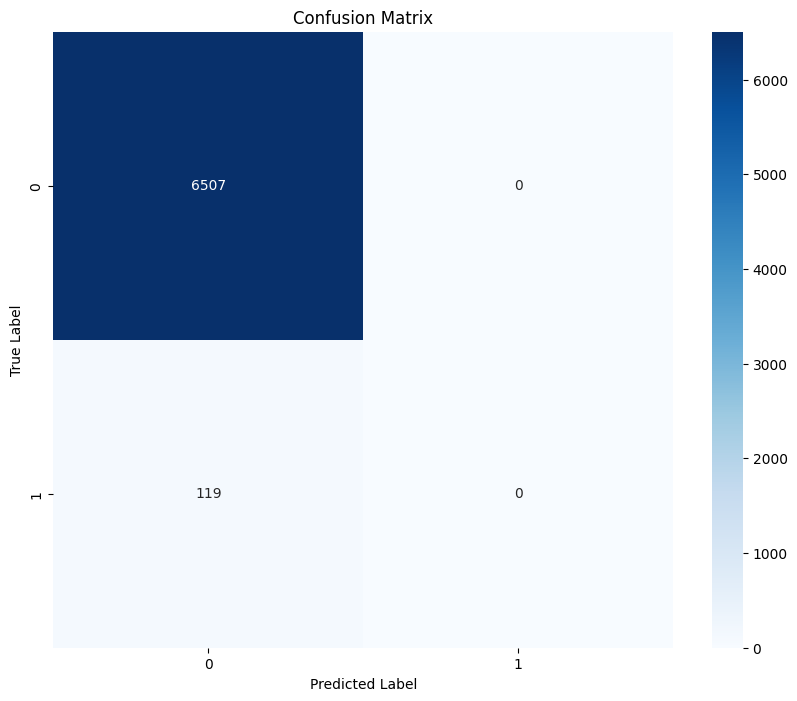

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test data
test_generator.reset()  # Reset the generator to ensure the model evaluates the entire test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Get class labels (class names)
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_labels, predicted_classes, target_names=class_labels, output_dict=True)

# Print the classification report
print("Classification Report:")
print(report)

# If you need individual metrics:
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
support = report['weighted avg']['support']

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Support: {support}')

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


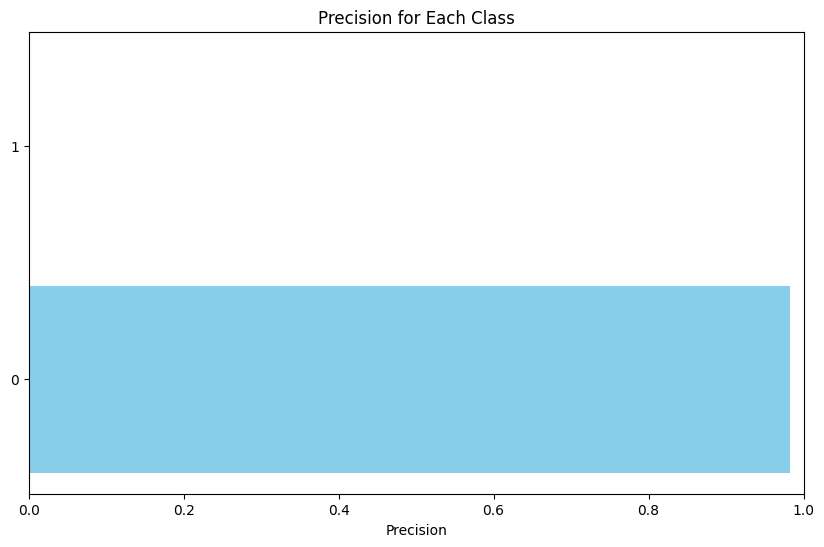

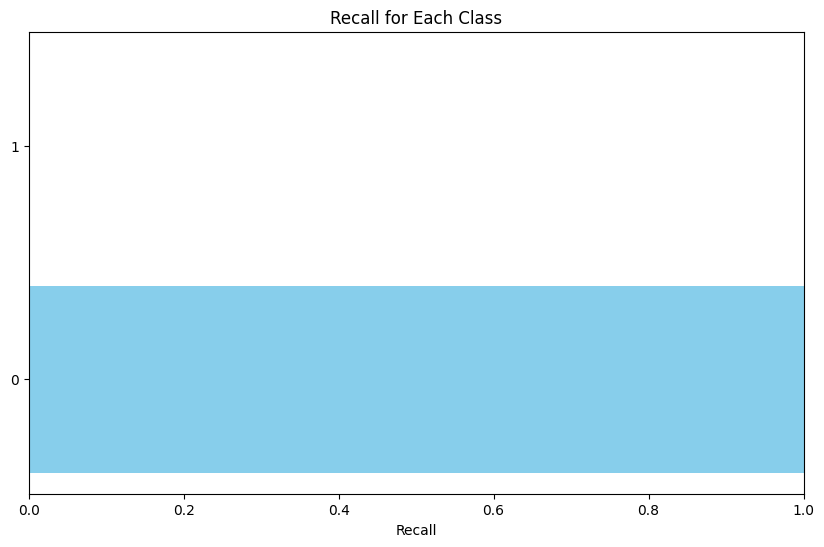

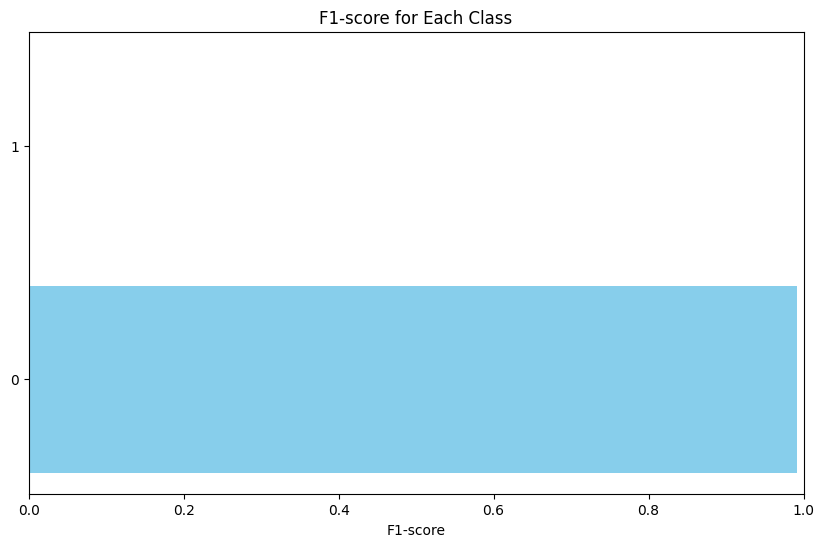

In [28]:
metrics = ['precision', 'recall', 'f1-score']
for metric in metrics:
    scores = [report[label][metric] for label in class_labels]
    
    plt.figure(figsize=(10, 6))
    plt.barh(class_labels, scores, color='skyblue')
    plt.xlabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} for Each Class')
    plt.xlim(0, 1)
    plt.show()

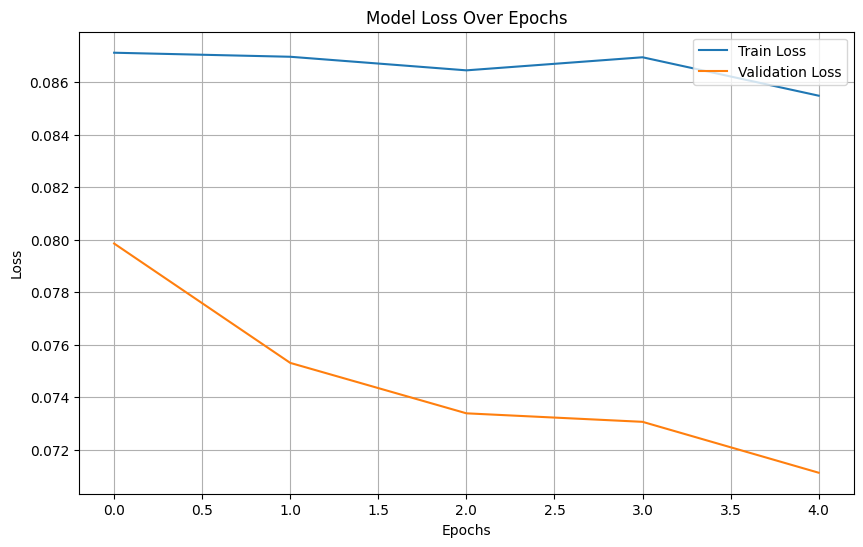

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Load validation data and labels
X_val, y_val = next(val_generator)

# Load the best model weights
model_path = 'from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Load validation data and labels
X_val, y_val = next(val_generator)

# Load the best model weights
model_path = 'skin_cancer_cnn_model.h5'
model = load_model(model_path)

# Predict on validation set
predictions = model.predict(X_val)

# Extract predicted labels and true labels
pred_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability
true_labels = np.argmax(y_val, axis=1)  # Assuming `y_val` is one-hot encoded

# Calculate metrics
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
'
model = load_model(model_path)

# Predict on validation set
predictions = model.predict(X_val)

# Extract predicted labels and true labels
pred_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability
true_labels = np.argmax(y_val, axis=1)  # Assuming `y_val` is one-hot encoded

# Calculate metrics
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
